Após gerar o arquivo via Etapa1.cpp, basta colocar o arquivo estatisticas.json junto a pasta desse arquivo .ipynb.

OBS.: É necessário ajustar o nome do arquivo, para `estatistica` concatenado com `_` e em seguida o nome do grafo utilizado, por exemplo: `BHW1`. Ajustar na linha:

`nomeArquivo = 'estatisticas.json'`

para o nome do arquivo gerado na Etapa1.cpp

por exemplo:

`nomeArquivo = 'estatisticas_BHW1.json'`



=== Estatísticas do Grafo ===
nome: BHW1
numVertices: 12
numArestas: 11
numArcos: 22
numVerticesRequeridos: 7
numArestasRequeridas: 11
numArcosRequeridos: 11
densidade: 0.333333
componentes: 1
grauMin: 4
grauMax: 10
caminhoMedio: 16.7121
diametro: 30
intermediacao: [18, 22, 6, 0, 14, 38, 22, 16, 14, 6, 0, 22]


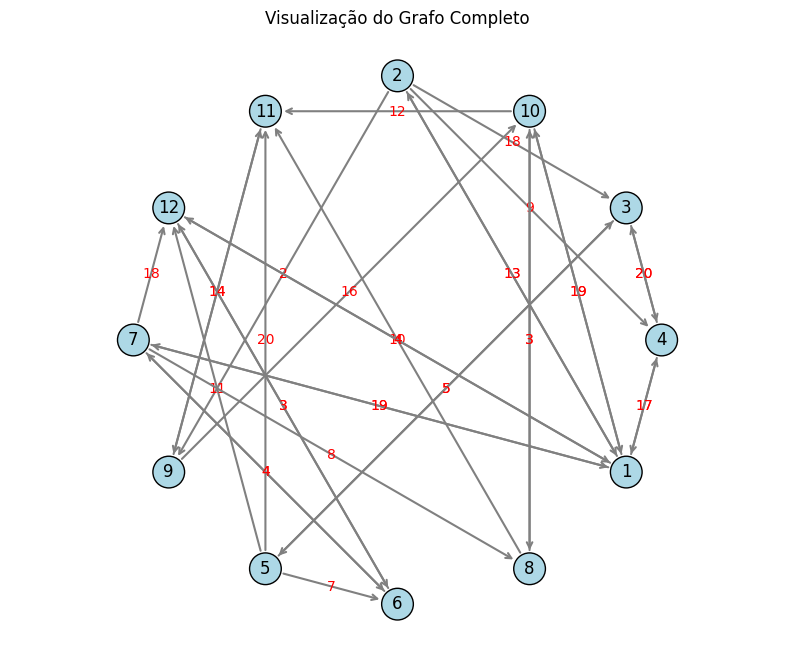

In [2]:
import json
import re
import math
import matplotlib.pyplot as plt

# Nome do arquivo com os dados JSON
nome_arquivo = 'estatisticas_BHW1.json'

# Carrega os dados do arquivo JSON
with open(nome_arquivo, 'r') as arquivo:
    dados = json.load(arquivo)

# Exibe as estatísticas do grafo
print("=== Estatísticas do Grafo ===")
for chave, valor in dados['estatisticas'].items():
    print(f"{chave}: {valor}")

# Recupera o conteúdo DOT
dot_texto = dados['grafo_dot']

# --- Extração dos Nós ---
# Usamos re.MULTILINE e âncora no início da linha para capturar somente definições explícitas de nós
padrao_nos = re.compile(r'^\s*(\S+)\s*\[label="([^"]+)"\]', re.MULTILINE)
nos = {}  # Dicionário: id do nó -> label
for match in padrao_nos.finditer(dot_texto):
    id_no = match.group(1)
    label_no = match.group(2)
    nos[id_no] = label_no

# --- Extração das Arestas ---
# Capturamos arestas com base no padrão, extraindo também o rótulo
padrao_arestas = re.compile(r'(\S+)\s*->\s*(\S+)\s*\[.*?label="([^"]+)"\]')
arestas = []  # Lista de tuplas (origem, destino, rótulo)
for match in padrao_arestas.finditer(dot_texto):
    origem = match.group(1)
    destino = match.group(2)
    rotulo = match.group(3)
    arestas.append((origem, destino, rotulo))

# --- Inclusão de Nós Implícitos ---
# Se um nó aparece nas arestas mas não foi declarado explicitamente, adiciona-o
for origem, destino, _ in arestas:
    if origem not in nos:
        nos[origem] = origem
    if destino not in nos:
        nos[destino] = destino

# --- Cálculo do Layout Circular ---
num_nos = len(nos)
raio_layout = 5  # Raio para distribuir os nós
posicoes = {}
for i, no in enumerate(nos.keys()):
    angulo = 2 * math.pi * i / num_nos
    x = raio_layout * math.cos(angulo)
    y = raio_layout * math.sin(angulo)
    posicoes[no] = (x, y)

# Parâmetros para desenho dos nós
raio_no = 0.3  # Raio do círculo que representa o nó

# Configuração da figura
plt.figure(figsize=(10, 8))
ax = plt.gca()

# --- Desenho dos Nós ---
# Cada nó é desenhado apenas uma vez, com um círculo e seu label centralizado
for no, (x, y) in posicoes.items():
    circulo = plt.Circle((x, y), raio_no, color='lightblue', ec='black', zorder=2)
    ax.add_patch(circulo)
    plt.text(x, y, nos[no], fontsize=12, ha='center', va='center', zorder=3)

# --- Desenho das Arestas ---
# Ajusta as coordenadas para que as setas iniciem e terminem na borda dos nós, e não em seus centros
for origem, destino, rotulo in arestas:
    x_origem, y_origem = posicoes[origem]
    x_destino, y_destino = posicoes[destino]

    # Vetor direção de origem para destino
    dx = x_destino - x_origem
    dy = y_destino - y_origem
    distancia = math.sqrt(dx**2 + dy**2)
    if distancia == 0:  # Evita divisão por zero (caso improvável)
        continue
    dx_norm = dx / distancia
    dy_norm = dy / distancia

    # Calcula as novas posições para a seta, deslocadas para a borda dos círculos
    novo_inicio = (x_origem + dx_norm * raio_no, y_origem + dy_norm * raio_no)
    novo_fim = (x_destino - dx_norm * raio_no, y_destino - dy_norm * raio_no)

    # Desenha a seta
    ax.annotate("",
                xy=novo_fim, xycoords='data',
                xytext=novo_inicio, textcoords='data',
                arrowprops=dict(arrowstyle="->", color="gray", lw=1.5))

    # Posiciona o label da aresta no ponto médio da nova trajetória
    meio_x = (novo_inicio[0] + novo_fim[0]) / 2
    meio_y = (novo_inicio[1] + novo_fim[1]) / 2
    plt.text(meio_x, meio_y, rotulo, fontsize=10, color='red', ha='center', va='center')

plt.title("Visualização do Grafo Completo")
plt.axis('equal')
plt.axis('off')
plt.show()